# Primeira etapa - Simulações numéricas essenciais.

In [2]:
import math
from cmath import *
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt

## Constantes

In [3]:
R1 = R2 = 0.5
L1 = L2 = 300e-3
C1 = C2 = 1e-6
k = 0.1
RC = 1

## Cálculos e simulações

In [4]:
m = k * math.sqrt(L1 * L2)
w = 1 / (math.sqrt(L1 * C1))
f_res = w / (2 * pi)

In [5]:
def CalcularTransformador(Uf, Rc, w, k):
    m = k * math.sqrt(L1 * L2)
    XL1 = w * L1 * 1j
    XC1 = 1/(w * C1 * 1j)
    XM = m * w * 1j
    XL2 = w * L2 * 1j
    XC2 = 1 / (w * C2 * 1j)
    Zrc_c2 = (Rc * XC2) / (Rc + XC2)
    Z = np.array([[R1 + XL1 + XC1, -XM], [-XM, XL2 + R2 + Zrc_c2]])
    V = np.array([Uf, 0])
    i = np.dot(linalg.inv(Z), V)
    return i[0], i[1]

Freq onde o I1 e max: 484.2646264626462


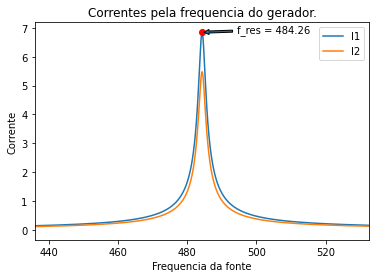

In [40]:
i1_list = []
i2_list = []
freqs = np.linspace(1, 1000, 10_000)
k = 0.8
for freq in freqs:
    w = 2 * pi * freq
    i1, i2 = CalcularTransformador(10, RC, w, k)
    i1_list.append(i1)
    i2_list.append(i2)

index_imax = i1_list.index(max(i1_list))
f_res = freqs[index_imax]
print(f"Freq onde o I1 e max: {f_res}")

ponto_ressonancia = (f_res, max(np.abs(i1_list)))

plt.plot(freqs, np.abs(i1_list), label='I1')
plt.plot(ponto_ressonancia[0], ponto_ressonancia[1], 'o', color='red')
plt.annotate(f"f_res = {f_res:.2f}", ponto_ressonancia, xytext=(f_res + 10, ponto_ressonancia[1]), arrowprops={"arrowstyle": 'simple'})
plt.plot(freqs, np.abs(i2_list), label='I2')
plt.title("Correntes pela frequencia do gerador.")
plt.xlabel('Frequencia da fonte')
plt.ylabel("Corrente")
plt.legend()
plt.xlim(f_res - 0.1*f_res, f_res + 0.1 * f_res)
plt.show()

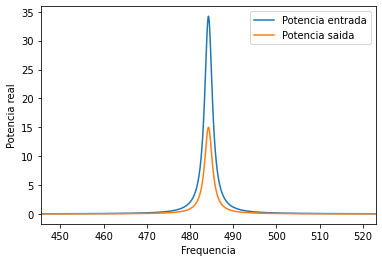

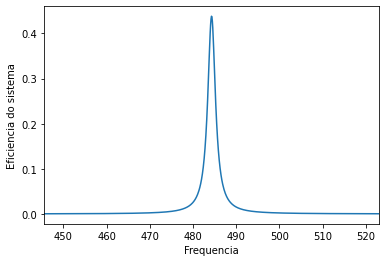

In [33]:
p_1 = []
p_2 = []

for i, freq in enumerate(freqs):
    p_1.append((10 * i1_list[i].conjugate()) / 2)
    z_c2 = 1 / (freq * 2 * pi * C2 * 1j)
    z_rcc2 = (z_c2 * RC) / (z_c2 + RC)
    u_rcc2 = z_rcc2 * i2_list[i]
    i_rc = u_rcc2 / RC 
    p_2.append((RC * i_rc * i_rc.conjugate()) / 2)

eficiencia = [p_2[i] / p_1[i] for i in range(0, len(p_1))]
f = freqs[p_1.index(max(p_1))]

plt.plot(freqs, np.real(p_1), label='Potencia entrada')
plt.plot(freqs, np.real(p_2), label='Potencia saida')
plt.xlabel("Frequencia")
plt.ylabel("Potencia real")
plt.xlim(f - 0.08*f, f + 0.08*f)
plt.legend()
plt.show()

plt.plot(freqs, np.real(eficiencia))
plt.xlabel("Frequencia")
plt.ylabel("Eficiencia do sistema")
plt.xlim(f - 0.08*f, f + 0.08*f)
plt.show()

c:\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


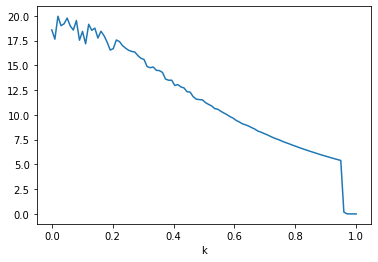

In [105]:
k_space = np.linspace(0, 1, 100)
i_maxs = []
for k in k_space:
    i1_list2 = []
    i2_list2 = []
    for freq in freqs:
        w = 2 * pi * freq
        i1, i2 = CalcularTransformador(10, RC, w, k)
        i1_list2.append(i1)
        i2_list2.append(i2)

    # index_imax = i1_list2.index(max(i1_list2))
    # f_res = freqs[index_imax]
    i_maxs.append(max(i1_list2))

plt.plot(k_space, i_maxs)
plt.xlabel("k")
plt.show()

In [107]:
index_imax = i_maxs.index(max(i_maxs))
k_max = k_space[index_imax]
k_max

0.020202020202020204